In [1]:
from fears.population import Population
from fears.utils import plotter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
dose_schedule = np.array([6,12,24,36,48])
dose = np.array([5,10,20,40])

options = {
    'mut_rate':1.4*10**-8,
    'use_carrying_cap':True,
    'carrying_cap':10**10,
    'dwell':True,
    'dwell_time':24*4,
    'death_model':'pharmacodynamic',
    'k_elim':0,
    'n_time_step':1000,
    'plot':False,
    'k_abs':0.95,
    'k_elim':0.00839,
    'max_dose':20,
    'regimen_length':21*24,
    'n_sims':1,
    'curve_type':'pulsed'
}

p = Population(**options)

cmap = mpl.cm.get_cmap('viridis')

res = np.zeros((len(dose_schedule),len(dose)))

n_sims = 10

ds_indx = 0
for ds in dose_schedule:
    d_indx = 0
    for d in dose:
        p.max_dose = d
        p.dose_schedule = ds
        p.reset_drug_conc_curve()

        if np.max(p.drug_curve) > 200:
            res[ds_indx,d_indx] = -1

        else:

            for i in range(n_sims):
                c = p.simulate()[0]
                c = np.sum(c,axis=1)
                if c[-1] == 0:
                    res[ds_indx,d_indx] += 1

        d_indx += 1
    ds_indx += 1

dose_schedule_res = res


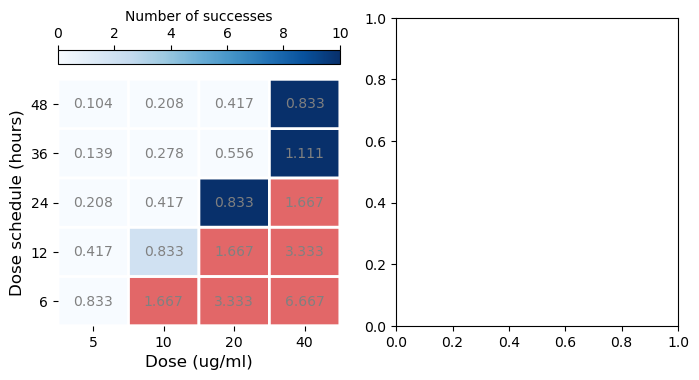

In [3]:
fig,ax_list = plt.subplots(ncols=2,figsize=(8,4))

# top = mpl.colormaps['Oranges_r']
# bottom = mpl.colormaps['Blues']

ax = ax_list[0]

cmap = mpl.colormaps['Blues']
cmap.set_under(color='tab:red',alpha=0.7)

# newcolors = np.vstack((top(np.linspace(0, 1, 128)),
#                        bottom(np.linspace(0, 1, 128))))

# newcmp = mpl.colors.ListedColormap(newcolors, name='OrangeBlue')

# ax.pcolor(res,cmap='viridis',origin='lower',extent=[0,np.max(dose),0,np.max(dose_schedule)],aspect='auto')
im = ax.pcolor(dose_schedule_res,cmap=cmap,edgecolors='white',linewidths=2,vmin=0,vmax=n_sims)

ax.set_xticks(np.arange(len(dose))+0.5)
ax.set_xticklabels(dose)
ax.set_yticks(np.arange(len(dose_schedule))+0.5)
ax.set_yticklabels(dose_schedule)

for i in range(len(dose_schedule)):
    for j in range(len(dose)):
        ann = str(round((1/dose_schedule[i])*dose[j],3))
        ax.text(j+0.5,i+0.5,ann,ha='center',va='center',color='gray')

ax.set_xlabel('Dose (ug/ml)',fontsize=12)
ax.set_ylabel('Dose schedule (hours)',fontsize=12)

cb = fig.colorbar(im,ax=ax,location='top',label='Number of successes')
# cb.set_ticks([-1,0,1])
# cb.set_ticklabels(['toxic','ineffective','effective'],rotation=-45)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [4]:
# fig,ax = plt.subplots(figsize=(4,3.5))
p.prob_drop = 0

ax = ax_list[1]
ds_indx = 0
effective_regimens = [] # (dose_schedule,dose)
for ds in dose_schedule:
    d_indx = 0
    for d in dose:
        p.max_dose = d
        p.dose_schedule = ds
        p.reset_drug_conc_curve()

        res_t = dose_schedule_res[ds_indx,d_indx]

        if res_t > 0:
            ax.plot(p.drug_curve,color=cmap(res_t),label='effective')
            effective_regimens.append((ds,d))
        elif res_t == 0:
            ax.plot(p.drug_curve,color='gray',label='innefective')
        elif res_t == -1:
            ax.plot(p.drug_curve,color=cmap(res_t),label='toxic')
        
        d_indx += 1
    ds_indx += 1

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique),frameon=False)

ax.set_xlabel('Time (hours)',fontsize=12)
ax.set_ylabel('Drug concentration (ug/ml)',fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pos = ax.get_position()
pos.x0 = pos.x0 + 0.05
pos.x1 = pos.x1 + 0.05

ax.set_position(pos)

# fig.tight_layout()
fig.savefig('../figures/dose_optimization.pdf',bbox_inches='tight')

In [5]:
res = np.zeros(len(effective_regimens))

simulated_regimens = {}

p.prob_drop = 0.2

n_sims = 100

indx = 0
for er in effective_regimens:
    p.max_dose = er[1]
    p.dose_schedule = er[0]
    
    drug_curve_list = []
    for i in range(n_sims):
        p.reset_drug_conc_curve()
        c = p.simulate()[0]
        c = np.sum(c,axis=1)
        drug_curve_list.append(p.drug_curve)
        if c[-1] == 0:
            res[indx] += 1

    simulated_regimens[er] = drug_curve_list
    indx += 1

res = res/n_sims

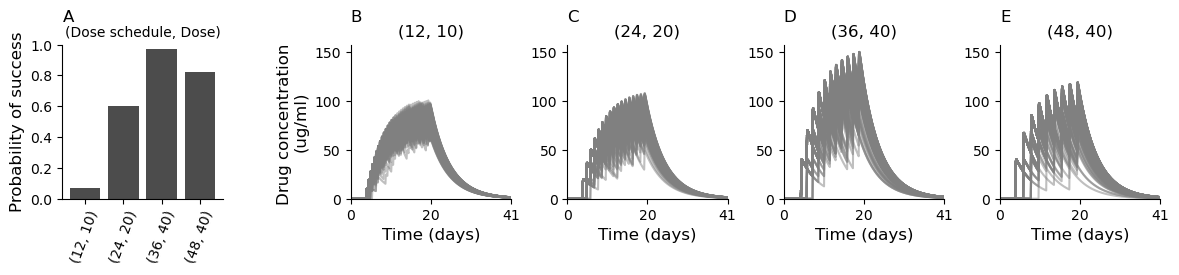

In [6]:
fig,ax_list = plt.subplots(ncols=5,figsize=(12,2))

labels = ['A','B','C','D','E']

ax = ax_list[0]

ax.bar(np.arange(len(effective_regimens)),res,color='k',alpha=0.7)

ax.set_xticks(np.arange(len(effective_regimens)))
ax.set_xticklabels(effective_regimens,rotation=70);

ax.set_title('(Dose schedule, Dose)',fontsize=10)

ax.set_ylim([0,1])
ax.set_ylabel('Probability of success',fontsize=12)

indx = 1
for er in effective_regimens:
    ax = ax_list[indx]
    for i in range(n_sims):
        ax.plot(simulated_regimens[er][i],color='gray',alpha=0.5)

    ax = plotter.x_ticks_to_days(p,ax)
    ax.set_title(str(er),fontsize=12)

    ax.set_xlabel('Time (days)',fontsize=12)
    indx += 1

ymax = 0
for ax in ax_list[1:]:
    if np.max(ax.get_ylim()) > ymax:
        ymax = np.max(ax.get_ylim())

for ax in ax_list[1:]:
    ax.set_ylim([0,ymax])

ax_list[1].set_ylabel('Drug concentration \n(ug/ml)',fontsize=12)

for ax in ax_list:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

shift = 0.08

ax_list[0].annotate(labels[0],xy=(0,1.15),xycoords='axes fraction',fontsize=12)

indx = 0
for ax in ax_list[1:]:
    # shift to the right by 0.07
    pos = ax.get_position()
    pos.x0 = pos.x0 + shift + (indx*0.02)
    pos.x1 = pos.x1 + shift + (indx*0.02)
    ax.set_position(pos)
    ax.annotate(labels[indx+1],xy=(0,1.15),xycoords='axes fraction',fontsize=12)
    indx += 1

fig.savefig('../figures/dose_opt_nonadherence.pdf',bbox_inches='tight')

